In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.linear_model import LogisticRegression

# Data Handling

In [35]:
# load the csv data file into a pandas dataframe and convert class into numerical data
df = pd.read_csv("data/star_classification.csv")
df["class"]=[0 if i == "GALAXY" else 1 if i == "STAR" else 2 for i in df["class"]]

In [36]:
# display first few values of the data
df.head()

,obj_ID,alpha,delta,u,g,r,i,z,run_ID,rerun_ID,cam_col,field_ID,spec_obj_ID,class,redshift,plate,MJD,fiber_ID
0,1.237661e+18,135.689107,32.494632,23.87882,22.27530,20.39501,19.16573,18.79371,3606,301,2,79,6.543777e+18,0,0.634794,5812,56354,171
1,1.237665e+18,144.826101,31.274185,24.77759,22.83188,22.58444,21.16812,21.61427,4518,301,5,119,1.176014e+19,0,0.779136,10445,58158,427
2,1.237661e+18,142.188790,35.582444,25.26307,22.66389,20.60976,19.34857,18.94827,3606,301,2,120,5.152200e+18,0,0.644195,4576,55592,299
3,1.237663e+18,338.741038,-0.402828,22.13682,23.77656,21.61162,20.50454,19.25010,4192,301,3,214,1.030107e+19,0,0.932346,9149,58039,775
4,1.237680e+18,345.282593,21.183866,19.43718,17.58028,16.49747,15.97711,15.54461,8102,301,3,137,6.891865e+18,0,0.116123,6121,56187,842


## Dealing with duplicates & irrelevant observations

In [37]:
# remove duplicates and verify
df = df.drop_duplicates()
df[df.duplicated()]

,obj_ID,alpha,delta,u,g,r,i,z,run_ID,rerun_ID,cam_col,field_ID,spec_obj_ID,class,redshift,plate,MJD,fiber_ID


In [38]:
# check for null values
df.isnull().sum()

obj_ID         0
alpha          0
delta          0
u              0
g              0
r              0
i              0
z              0
run_ID         0
rerun_ID       0
cam_col        0
field_ID       0
spec_obj_ID    0
class          0
redshift       0
plate          0
MJD            0
fiber_ID       0
dtype: int64

In [39]:
# create a classifier to detect anomalies in the dataset
clf = LocalOutlierFactor()
y_pred = clf.fit_predict(df)
x_score = clf.negative_outlier_factor_
outlier_score = pd.DataFrame()
outlier_score["score"] = x_score

In [40]:
# create index to filter outlier based on a threshold
filter_outlier = outlier_score["score"] < -1.5
outlier_index = outlier_score[filter_outlier].index.tolist()
len(outlier_index)

15256

In [41]:
# drop outliers from dataframe
df.drop(outlier_index, inplace=True)
# df.reset_index(inplace = True)
df.head()

,obj_ID,alpha,delta,u,g,r,i,z,run_ID,rerun_ID,cam_col,field_ID,spec_obj_ID,class,redshift,plate,MJD,fiber_ID
0,1.237661e+18,135.689107,32.494632,23.87882,22.27530,20.39501,19.16573,18.79371,3606,301,2,79,6.543777e+18,0,0.634794,5812,56354,171
1,1.237665e+18,144.826101,31.274185,24.77759,22.83188,22.58444,21.16812,21.61427,4518,301,5,119,1.176014e+19,0,0.779136,10445,58158,427
3,1.237663e+18,338.741038,-0.402828,22.13682,23.77656,21.61162,20.50454,19.25010,4192,301,3,214,1.030107e+19,0,0.932346,9149,58039,775
4,1.237680e+18,345.282593,21.183866,19.43718,17.58028,16.49747,15.97711,15.54461,8102,301,3,137,6.891865e+18,0,0.116123,6121,56187,842
6,1.237679e+18,23.234926,11.418188,21.46973,21.17624,20.92829,20.60826,20.42573,7773,301,2,462,1.246262e+19,2,0.586455,11069,58456,113


## Feature Selection

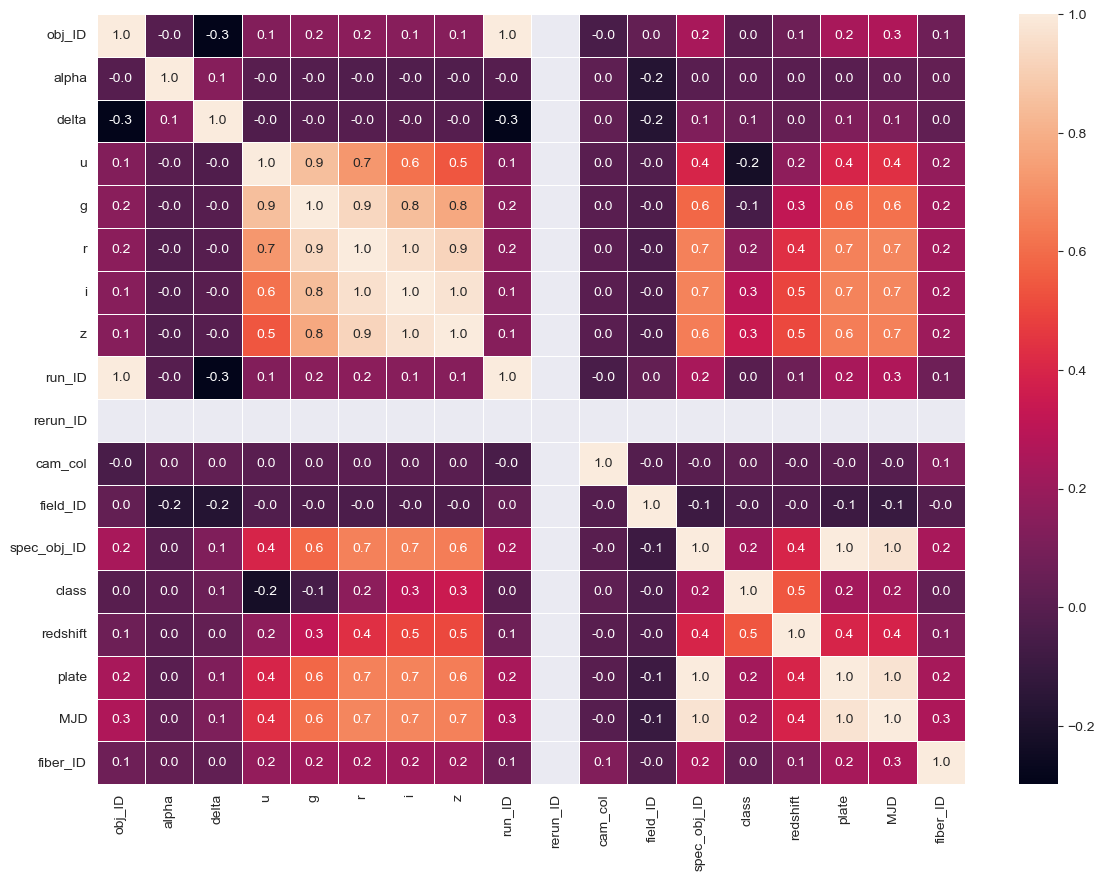

In [42]:
plt.figure(figsize = (14,10))
sns.heatmap(df.corr(), annot=True, fmt= ".1f", linewidths= .7)
plt.show()

In [43]:
# check correlation between values and the resulting class
correlation = df.corr()
correlation["class"].sort_values()

u             -0.222756
g             -0.058155
field_ID      -0.037529
run_ID         0.000245
obj_ID         0.000247
alpha          0.008183
cam_col        0.017749
fiber_ID       0.037349
delta          0.058952
r              0.160680
MJD            0.214441
spec_obj_ID    0.224728
plate          0.224729
i              0.294096
z              0.349730
redshift       0.541684
class          1.000000
rerun_ID            NaN
Name: class, dtype: float64

In [44]:
# therefore we can drop the columns that do not have a positive/negative (between -0.5 and 0.5) or a NaN correlation with the class column
df.drop(["field_ID", "run_ID", "obj_ID", "alpha", "cam_col", "fiber_ID", "delta", "rerun_ID"], axis=1, inplace=True)

In [45]:
df.head()

,u,g,r,i,z,spec_obj_ID,class,redshift,plate,MJD
0,23.87882,22.27530,20.39501,19.16573,18.79371,6.543777e+18,0,0.634794,5812,56354
1,24.77759,22.83188,22.58444,21.16812,21.61427,1.176014e+19,0,0.779136,10445,58158
3,22.13682,23.77656,21.61162,20.50454,19.25010,1.030107e+19,0,0.932346,9149,58039
4,19.43718,17.58028,16.49747,15.97711,15.54461,6.891865e+18,0,0.116123,6121,56187
6,21.46973,21.17624,20.92829,20.60826,20.42573,1.246262e+19,2,0.586455,11069,58456


## Data Imbalance

In [46]:
# assign x as the df without the class column, and y as the value of the class column.
x = df.drop(["class"], axis = 1)
y = df.loc[:, "class"].values

In [47]:
# correct data imbalances by using SMOTE technique to duplicate values and fit_resample to resample minority classes.
sm = SMOTE(random_state = 39)
print("Original Dataset Shape %s" % Counter(y))
x, y = sm.fit_resample(x, y)
print("Resampled Dataset Shape %s" % Counter(y))

Original Dataset Shape Counter({0: 50696, 1: 17890, 2: 16158})
Resampled Dataset Shape Counter({0: 50696, 2: 50696, 1: 50696})


C:\Users\misha\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


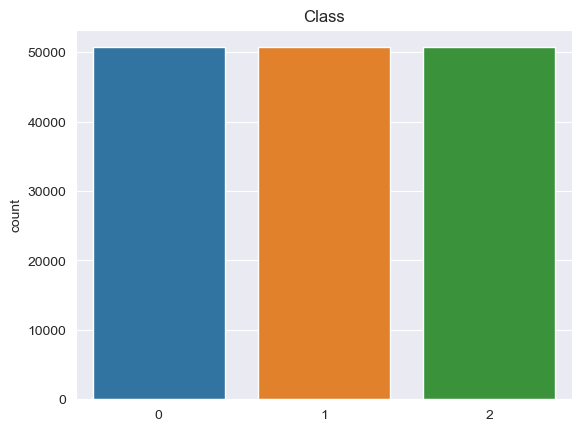

In [48]:
# plot of classes after resampling.
sns.countplot(y)
plt.title("Class")
plt.show()

## PCA

In [49]:
# standardize the 'x' dataset by removing the mean and scaling to unit variance.
scaler = StandardScaler()
x = scaler.fit_transform(x)

In [50]:
# performs (PCA) on the 'x' dataset, selects the top 4 principal components, and combines them with the 'y' dataset, creating a final dataset 'final_DF'.
y = pd.DataFrame(y, columns=["class"])
pca = PCA(0.95)
p_Components = pca.fit_transform(x)
p_DF = pd.DataFrame(data= p_Components, columns= ["Principal Components 1", "Principle Components 2", "Principal Components 3", "Principal Components 4"])
final_DF = pd.concat([p_DF, y[["class"]]], axis=1)
final_DF

,Principal Components 1,Principle Components 2,Principal Components 3,Principal Components 4,class
0,-0.883760,-0.610128,-0.741976,-0.712579,0
1,-4.015936,0.117776,-0.926752,0.067478,0
2,-2.726679,0.536000,-0.658118,-0.209193,0
3,2.879574,2.372304,-0.921510,-0.790939,0
4,-2.698155,1.773602,-0.753032,0.555378,2
...,...,...,...,...,...
152083,-2.319806,-0.569335,0.087152,0.351870,2
152084,-1.501721,0.348722,1.245516,-0.079903,2
152085,-0.896792,1.361279,0.798018,0.117548,2
152086,-2.351540,1.325487,1.648124,-0.558974,2


## Train & Test Data Split

In [54]:
x_train, x_test, y_train, y_test = train_test_split(p_DF, y, test_size= 0.25, random_state=42)
print("x_train: {}".format(x_train.shape))
print("x_test: {}".format(x_test.shape))
print("y_train: {}".format(y_train.shape))
print("y_test: {}".format(y_test.shape))

x_train: (114066, 4)
x_test: (38022, 4)
y_train: (114066, 1)
y_test: (38022, 1)


# Modelling

## Logistic Regression Model

In [56]:
lr = LogisticRegression(multi_class='multinomial', solver='lbfgs')
lr.fit(x_train, y_train)

C:\Users\misha\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(multi_class='multinomial')

In [58]:
y_pred = lr.predict(x_test)
y_pred

array([1, 0, 0, ..., 2, 2, 2], dtype=int64)

In [60]:
# Evaluate Model
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
print(cm)


[[11770   417   429]
 [    2 12710     2]
 [  742     1 11949]]


In [61]:
from sklearn.metrics import accuracy_score
print(accuracy_score(y_test, y_pred))

0.9581032034085529
